# Database Connection - Linear Regression - Spliting dataset into Train and Test sets

### Outline:

- connect to Postgres Database in AWS.
- load economic features and target table into Dataframe
- additional Data manipulation in Dataframe
- train model and evaluate results

## Import Dependencies
**config.py**  file is needed to connect to AWS database

You may need to run these pip install in the correct conda environment:

`$   pip install psycopg2`

`$   pip install psycopg2-binary `

In [50]:
%matplotlib inline

In [1]:
# Import dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds
import pandas as pd

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.datasets as datasets

# For splitting of data into train and test set
from sklearn.model_selection import train_test_split

# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import f1_score,accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics

In [2]:
#!pip install psycopg2

In [3]:
#!pip install psycopg2-binary 

## Connect to postgres database in AWS, read data into a Dataframe

In [2]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [3]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# List tables in database
inspect(engine).get_table_names()

['high_low_poverty',
 'ave_wage_indexing',
 'welfare_education',
 'economic_features_full',
 'economic_features',
 'lowest_poverty_rates',
 'highest_poverty_rates',
 'cpi_inflation_rate',
 'crime_rate',
 'divorce_rate',
 'homeownership_rate',
 'min_wage_effective',
 'poverty_rates',
 'unemployment_rate']

In [6]:
# List columns in a specific table ('min_wage')
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [7]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [8]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

year     state  population_million  education_million  welfare_million  \
0  1970  National             203.302            56456.0          18738.8   
1  1971  National             205.515            63469.0          27364.3   
2  1972  National             207.752            71351.0          30594.3   
3  1973  National             210.013            75849.0          28944.9   
4  1974  National             212.299            81440.0          34816.4   

   crime_rate  unemployment_rate  divorce_rate_per_1000_people  \
0       363.5                NaN                          3.50   
1       396.0                NaN                          3.75   
2       401.0                NaN                          4.00   
3       417.4                NaN                          4.25   
4       461.1                NaN                          4.50   

   homeownership_rate  minimum_wage_effective  cpi_average  inflation_rate  \
0                 NaN                1.382353         38.8             5.8   
1                 NaN                1.382353         40.5             4.3   
2                 NaN                1.623529         41.8             3.3   
3                 NaN                1.623529         44.4             6.2   
4                 NaN                1.623529         49.3            11.1   

   avg_wage_index  poverty_rate  
0         6186.24         17.18  
1         6497.08         17.05  
2         7133.80         16.12  
3         7580.16         15.13  
4         8030.76         15.86

## Additional data processing

In [9]:
# Calculate additional features

econ_features_full['education_per_capita'] = econ_features_full['education_million'] / econ_features_full['population_million']
econ_features_full['welfare_per_capita'] = econ_features_full['welfare_million'] / econ_features_full['population_million']


In [10]:
# Drop the non-beneficial columns
columns_to_drop = ['education_million','welfare_million']
model_df = econ_features_full.drop(columns=columns_to_drop, axis=1)

# Drop 'District of Columbia' information
model_df.drop(model_df[model_df['state']=='District of Columbia'].index, inplace=True)

model_df.head()

year     state  population_million  crime_rate  unemployment_rate  \
0  1970  National             203.302       363.5                NaN   
1  1971  National             205.515       396.0                NaN   
2  1972  National             207.752       401.0                NaN   
3  1973  National             210.013       417.4                NaN   
4  1974  National             212.299       461.1                NaN   

   divorce_rate_per_1000_people  homeownership_rate  minimum_wage_effective  \
0                          3.50                 NaN                1.382353   
1                          3.75                 NaN                1.382353   
2                          4.00                 NaN                1.623529   
3                          4.25                 NaN                1.623529   
4                          4.50                 NaN                1.623529   

   cpi_average  inflation_rate  avg_wage_index  poverty_rate  \
0         38.8             5.8         6186.24         17.18   
1         40.5             4.3         6497.08         17.05   
2         41.8             3.3         7133.80         16.12   
3         44.4             6.2         7580.16         15.13   
4         49.3            11.1         8030.76         15.86   

   education_per_capita  welfare_per_capita  
0            277.695251           92.172236  
1            308.829039          133.149892  
2            343.443144          147.263564  
3            361.163357          137.824325  
4            383.609909          163.997004

## Model for 1 state

In [11]:
# List of states
model_df.state.unique()

array(['National', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Michigan', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'New Jersey', 'Nevada', 'New Hampshire', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [12]:
# Pick data for 1 state
state_to_model = 'Texas'
model_state_df = model_df.loc[model_df['state']==state_to_model].dropna().set_index('year')
model_state_df.drop(columns=['state'], inplace=True)
model_state_df

population_million  crime_rate  unemployment_rate  \
year                                                      
1984              15.274       505.0                6.1   
1985              15.547       550.0                7.0   
1986              15.825       658.9                8.8   
1987              16.108       631.1                8.5   
1988              16.395       652.6                7.4   
1989              16.688       658.5                6.7   
1990              16.987       761.4                6.4   
1991              17.338       840.1                7.0   
1992              17.698       806.3                7.7   
1993              18.064       762.1                7.2   
1994              18.438       706.5                6.6   
1995              18.820       663.9                6.1   
1996              19.210       644.4                5.8   
1997              19.608       602.5                5.4   
1998              20.014       564.6                5.0   
1999              20.429       560.3                4.7   
2000              20.946       545.1                4.4   
2001              21.333       571.6                5.0   
2002              21.711       579.7                6.3   
2003              22.058       553.1                6.7   
2004              22.418       540.9                6.0   
2005              22.802       528.1                5.5   
2006              23.369       517.3                5.0   
2007              23.838       510.4                4.4   
2008              24.304       508.0                4.9   
2009              24.782       491.0                7.5   
2010              25.242       448.4                8.2   
2011              25.646       408.6                8.0   
2012              26.084       408.6                6.7   
2013              26.480       410.3                6.3   
2014              26.963       406.7                5.2   

      divorce_rate_per_1000_people  homeownership_rate  \
year                                                     
1984                        4.9778                62.5   
1985                        4.9222                60.5   
1986                        4.8667                61.0   
1987                        4.8111                61.1   
1988                        4.7556                59.9   
1989                        4.7000                61.0   
1990                        4.7000                59.7   
1991                        4.6429                59.0   
1992                        4.5857                58.3   
1993                        4.5286                58.7   
1994                        4.4714                59.7   
1995                        4.4143                61.4   
1996                        4.3571                61.8   
1997                        4.3000                61.5   
1998                        4.2000                62.5   
1999                        4.1000                62.9   
2000                        4.0000                63.8   
2001                        4.0000                63.9   
2002                        3.9000                63.4   
2003                        3.8000                64.5   
2004                        3.7000                65.5   
2005                        3.6000                65.9   
2006                        3.7000                66.0   
2007                        3.6000                66.0   
2008                        3.5000                65.5   
2009                        3.5000                65.4   
2010                        3.6000                65.3   
2011                        3.6000                64.3   
2012                        3.4000                64.3   
2013                        3.3000                63.3   
2014                        3.2000                62.2   

      minimum_wage_effective  cpi_average  inflation_rate  avg_wage_index  \
year                                                              

In [13]:
# Define X and y variables
X = model_state_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y = model_state_df["poverty_rate"]
print(f'X shape: {X.shape}')
X.head()

X shape: (31, 11)


population_million  crime_rate  unemployment_rate  \
year                                                      
1984              15.274       505.0                6.1   
1985              15.547       550.0                7.0   
1986              15.825       658.9                8.8   
1987              16.108       631.1                8.5   
1988              16.395       652.6                7.4   

      divorce_rate_per_1000_people  homeownership_rate  \
year                                                     
1984                        4.9778                62.5   
1985                        4.9222                60.5   
1986                        4.8667                61.0   
1987                        4.8111                61.1   
1988                        4.7556                59.9   

      minimum_wage_effective  cpi_average  inflation_rate  avg_wage_index  \
year                                                                        
1984                    3.35        103.9             4.3        16135.07   
1985                    3.35        107.6             3.5        16822.51   
1986                    3.35        109.6             1.9        17321.82   
1987                    3.35        113.6             3.7        18426.51   
1988                    3.35        118.3             4.1        19334.04   

      education_per_capita  welfare_per_capita  
year                                            
1984            841.894723          201.839728  
1985            915.642889          205.628095  
1986            986.350711          224.000000  
1987            988.999255          272.547802  
1988           1021.018603          264.812443

In [14]:
model_state_df.dtypes

population_million              float64
crime_rate                      float64
unemployment_rate               float64
divorce_rate_per_1000_people    float64
homeownership_rate              float64
minimum_wage_effective          float64
cpi_average                     float64
inflation_rate                  float64
avg_wage_index                  float64
poverty_rate                    float64
education_per_capita            float64
welfare_per_capita              float64
dtype: object

In [82]:
#  CHECK IF THIS IS NEEDED ********************************************
# std = preprocessing.StandardScaler()
# X is a matrix
#std.fit(X)
#X_std = std.transform(X)

In [15]:
# Create a model with scikit-learn
model = LinearRegression()

In [32]:
# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model.fit(X_train, y_train)

LinearRegression()

In [17]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
#model.fit(X, y)

In [33]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values

#  Predict using all X values for ease of plotting.
y_pred = model.predict(X)
print(y_pred.shape)
print(X.shape)

# Use y_pred_test to plot testing points
y_pred_test = model.predict(X_test)

(31,)
(31, 11)


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print(f'Mean absolute error: {mean_absolute_error(y_test,y_pred_test)}')
print(f'Mean square error: {mean_squared_error(y_test,y_pred_test)}')
print(f'r2 score: {r2_score(y_test,y_pred_test)}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean absolute error: 0.2543042682881804
Mean square error: 0.09943822464781546
r2 score: 0.9802349788749677
Coefficients: [ 2.41982361e+00  3.01497684e-03  4.65066811e-01 -7.79608876e-01
 -5.22619587e-02 -6.52938667e-01 -1.15155614e-01  4.09719547e-01
 -4.37371908e-04 -1.28770216e-03 -4.23176197e-03]
Intercept: 9.224040540385433


In [35]:
model_state_df['predicted_poverty'] = y_pred
model_state_df.head()

population_million  crime_rate  unemployment_rate  \
year                                                      
1984              15.274       505.0                6.1   
1985              15.547       550.0                7.0   
1986              15.825       658.9                8.8   
1987              16.108       631.1                8.5   
1988              16.395       652.6                7.4   

      divorce_rate_per_1000_people  homeownership_rate  \
year                                                     
1984                        4.9778                62.5   
1985                        4.9222                60.5   
1986                        4.8667                61.0   
1987                        4.8111                61.1   
1988                        4.7556                59.9   

      minimum_wage_effective  cpi_average  inflation_rate  avg_wage_index  \
year                                                                        
1984                    3.35        103.9             4.3        16135.07   
1985                    3.35        107.6             3.5        16822.51   
1986                    3.35        109.6             1.9        17321.82   
1987                    3.35        113.6             3.7        18426.51   
1988                    3.35        118.3             4.1        19334.04   

      poverty_rate  education_per_capita  welfare_per_capita  \
year                                                           
1984          22.4            841.894723          201.839728   
1985          22.4            915.642889          205.628095   
1986          22.6            986.350711          224.000000   
1987          22.7            988.999255          272.547802   
1988          22.3           1021.018603          264.812443   

      predicted_poverty  
year                     
1984          22.011295  
1985          22.208496  
1986          22.790753  
1987          22.875205  
1988          22.446157

In [36]:
X_test

population_million  crime_rate  unemployment_rate  \
year                                                      
2008              24.304       508.0                4.9   
1996              19.210       644.4                5.8   
1988              16.395       652.6                7.4   
2005              22.802       528.1                5.5   
1994              18.438       706.5                6.6   
2007              23.838       510.4                4.4   
2010              25.242       448.4                8.2   

      divorce_rate_per_1000_people  homeownership_rate  \
year                                                     
2008                        3.5000                65.5   
1996                        4.3571                61.8   
1988                        4.7556                59.9   
2005                        3.6000                65.9   
1994                        4.4714                59.7   
2007                        3.6000                66.0   
2010                        3.6000                65.3   

      minimum_wage_effective  cpi_average  inflation_rate  avg_wage_index  \
year                                                                        
2008                    5.85      215.303             3.8        41334.97   
1996                    4.25      156.900             2.9        25913.90   
1988                    3.35      118.300             4.1        19334.04   
2005                    5.15      195.300             3.4        36952.94   
1994                    4.25      148.200             2.6        23753.53   
2007                    5.15      207.342             2.9        40405.48   
2010                    7.25      218.056             1.6        41673.83   

      education_per_capita  welfare_per_capita  
year                                            
2008           2732.035879          278.826531  
1996           1462.529932          279.604373  
1988           1021.018603          264.812443  
2005           2332.764670          288.110692  
1994           1339.581299          282.481831  
2007           2494.429063          266.607937  
2010           2967.130180          548.474764

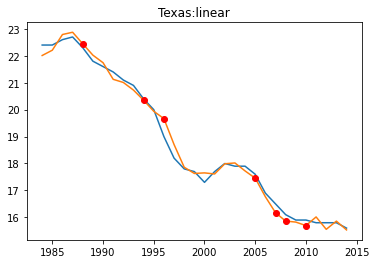

In [42]:
# Plot the results. The best fit line is red.
#model_state_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=state_to_model )
plt.plot(model_state_df.index.values, model_state_df['poverty_rate'],
         model_state_df.index.values,model_state_df['predicted_poverty'])
plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state_to_model}:linear')
plt.show()

#plt.plot(X, y_pred, color='red')
#plt.show()

In [38]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[ 2.41982361e+00  3.01497684e-03  4.65066811e-01 -7.79608876e-01
 -5.22619587e-02 -6.52938667e-01 -1.15155614e-01  4.09719547e-01
 -4.37371908e-04 -1.28770216e-03 -4.23176197e-03]
9.224040540385433


## Create Function

In [80]:
# create, train and test a model on dataframe df, filtering on state using the model_type

def run_model(df, model_type='linear'):
    training_size = 0.9
    result_df = pd.DataFrame()
    rows_plots = len(df.state.unique())
    fig, ax = plt.subplots(rows_plots, 1 , figsize=(20, 5*rows_plots))
    
    for row, state in enumerate(df.state.unique()):
        m_df = df.loc[df['state']==state].dropna().set_index('year')
        m_df.drop(columns=['state'], inplace=True)

    # Define X and y variables
        X = m_df.drop(["poverty_rate"], axis=1)
        y = m_df["poverty_rate"]

    # Create a model with scikit-learn
        if model_type=='linear':
            model = LinearRegression()
        elif model_type =='ridge':
            model = Ridge(alpha=0.5)
        elif model_type == 'lasso':
            model = Lasso(alpha=0.1, max_iter=1500, tol=0.01)
        else:
            model = LinearRegression()
    
    # Test the model by using train and test dataset
    # Fit the data into the model
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_size)
        model.fit(X_train, y_train)
    
    # We use the predict() on the model to predict the output
    # The model creates predicted y values based on X values
        y_pred = model.predict(X)
        m_df['predicted_poverty'] = y_pred
    
    # Use y_pred_test to plot testing points
        y_pred_test = model.predict(X_test)
    
    #m_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=f'{state}:{model_type}')
        ax[row].plot(m_df.index.values, m_df['poverty_rate'],
             m_df.index.values, m_df['predicted_poverty'])
        ax[row].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
        ax[row].set_title(f'{state}:{model_type}')
    
        result = { 'State': state,
                    'Model': model_type,
                    'Mean absolute error': mean_absolute_error(y_test,y_pred_test),
                    'Mean square error': mean_squared_error(y_test,y_pred_test),
                    'r2 score': r2_score(y_test,y_pred_test),
                    'Coefficients': model.coef_,
                    'Intercept': model.intercept_
                  }
        result_df = result_df.append(result, ignore_index=True)
    plt.show()
    return result_df
    

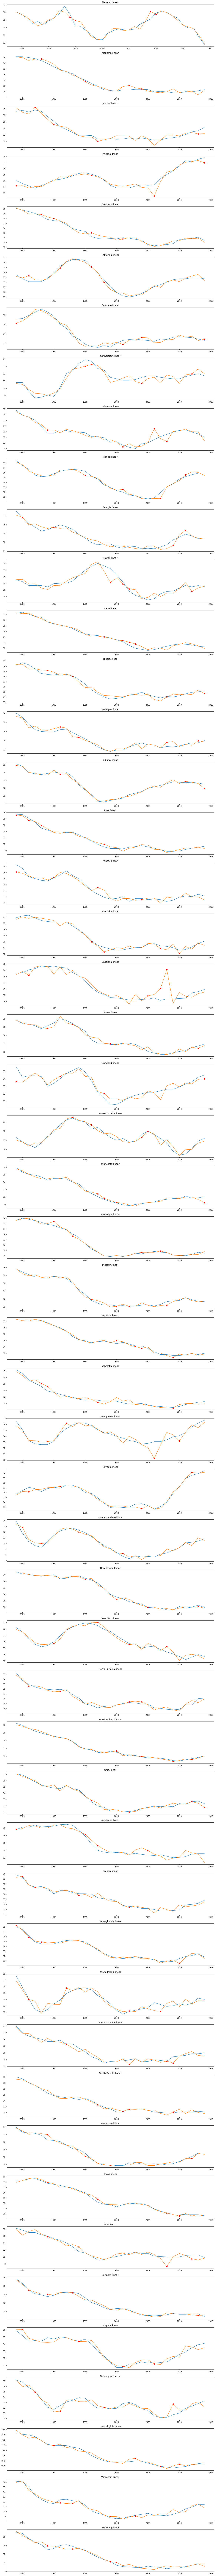

In [81]:
result_df = pd.DataFrame()

result = run_model(model_df, 'linear')
result_df = result_df.append(result, ignore_index=True)


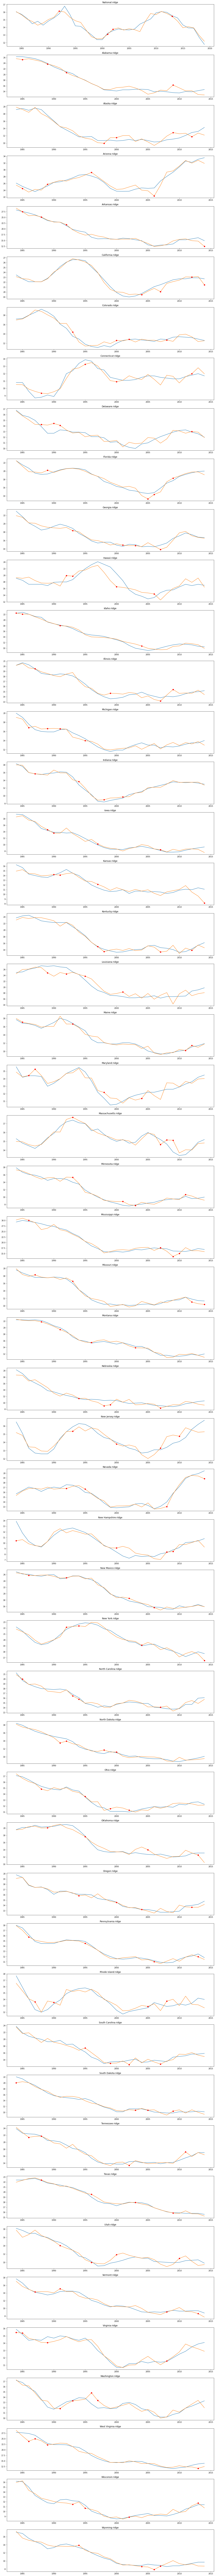

In [82]:
result = run_model(model_df, 'ridge')
result_df = result_df.append(result, ignore_index=True)

C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.966868531703238, tolerance: 0.5031109999999999
  positive)
C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.399606251242945, tolerance: 6.371393548387097
  positive)
C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.73850573932328, tolerance: 2.6330733548387095
  positive)
C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the n

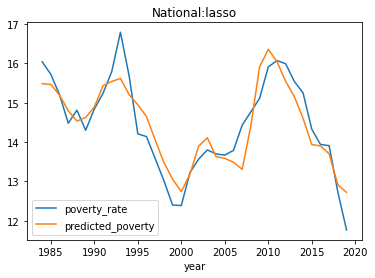

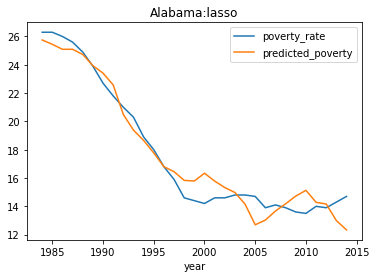

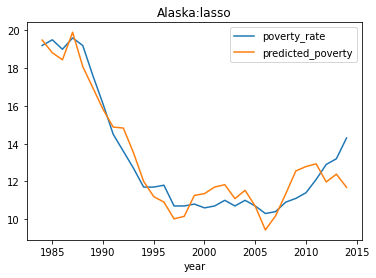

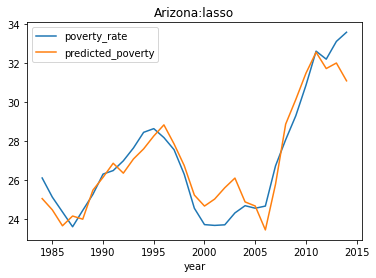

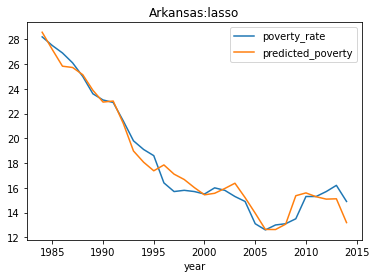

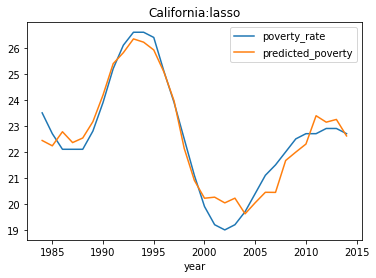

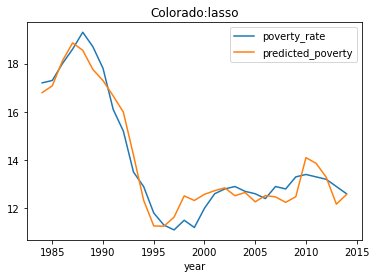

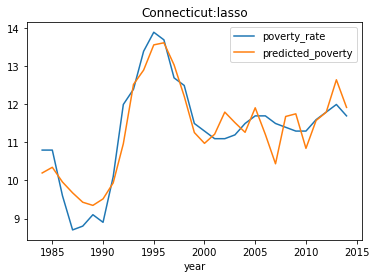

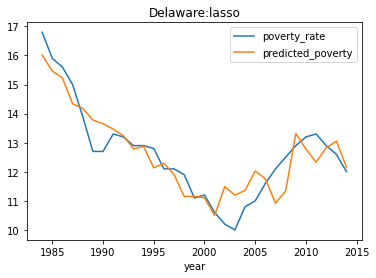

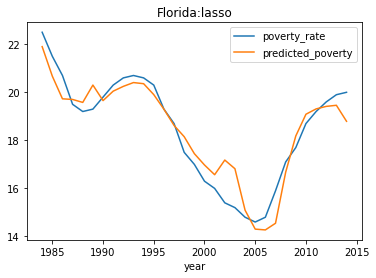

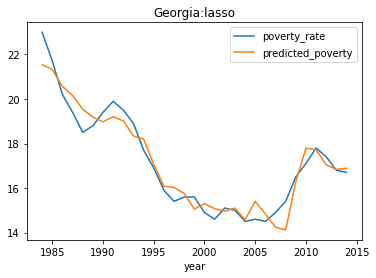

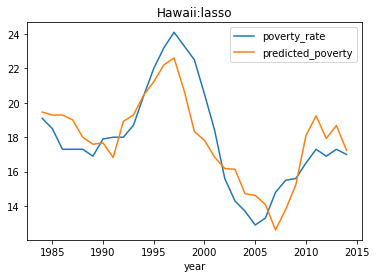

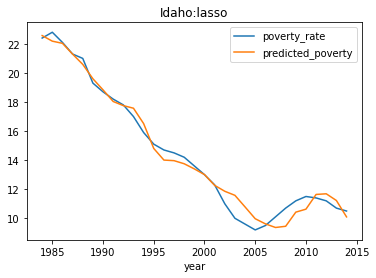

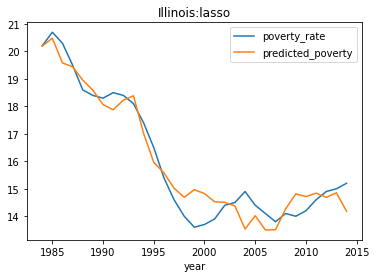

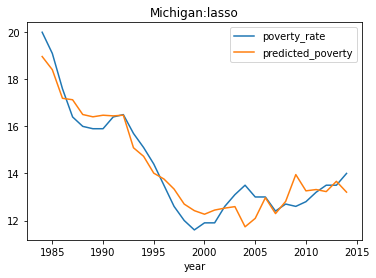

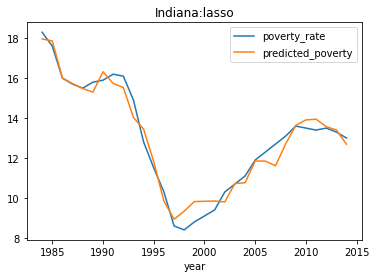

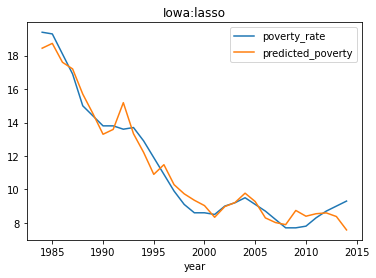

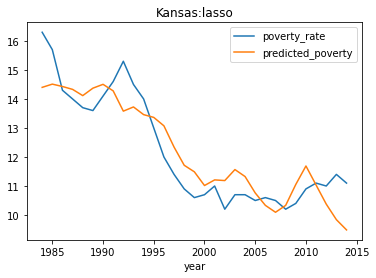

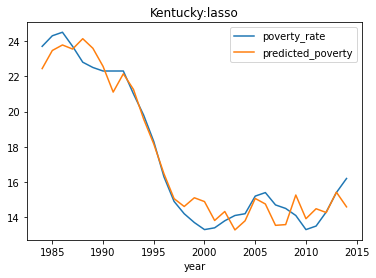

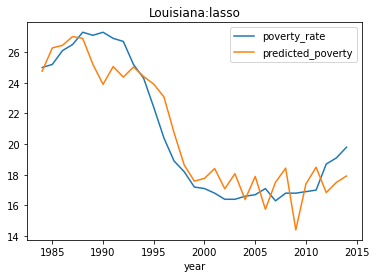

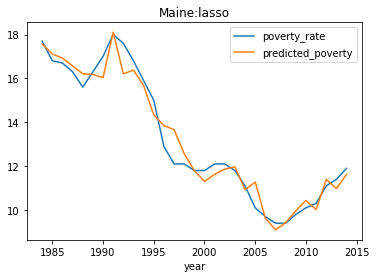

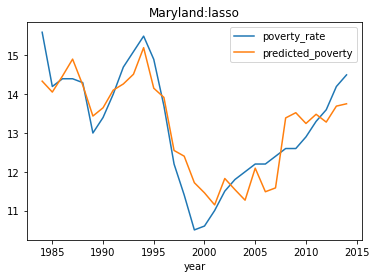

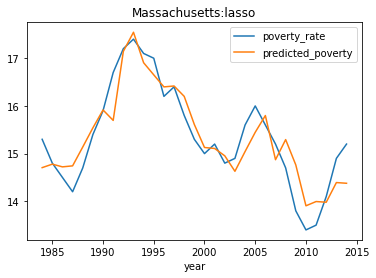

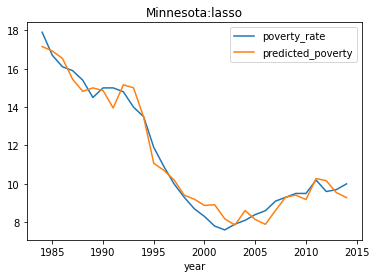

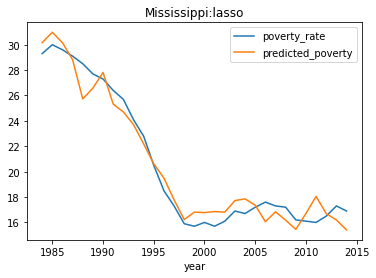

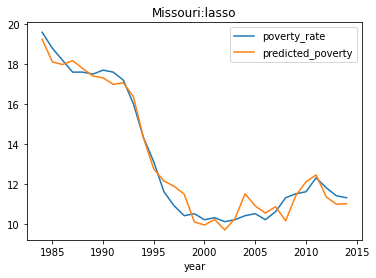

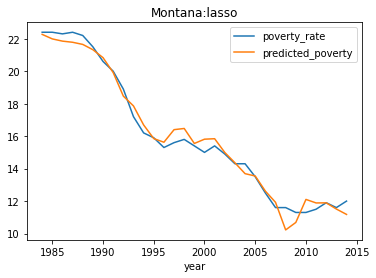

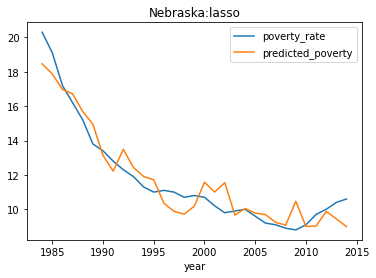

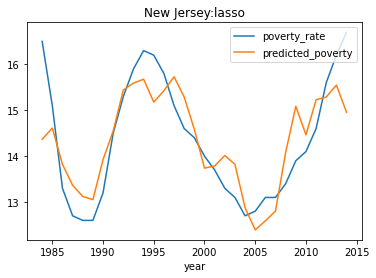

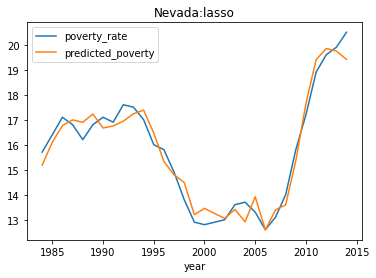

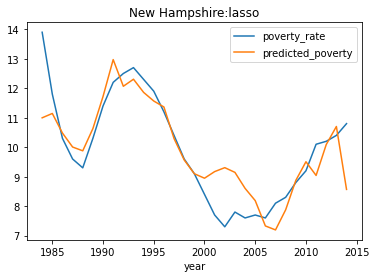

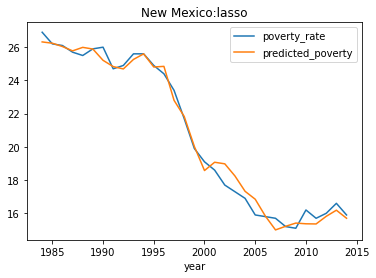

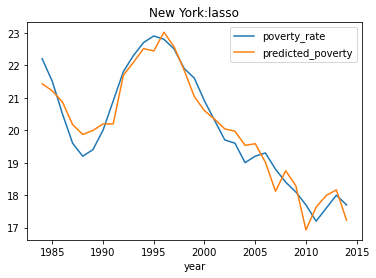

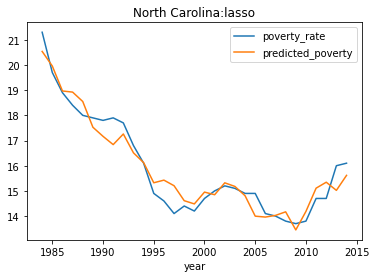

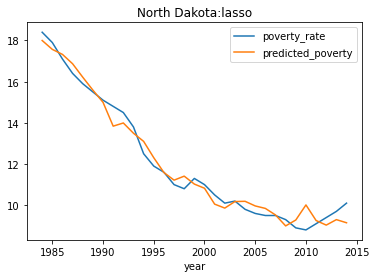

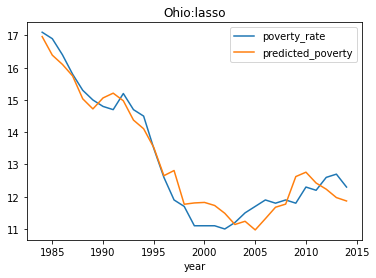

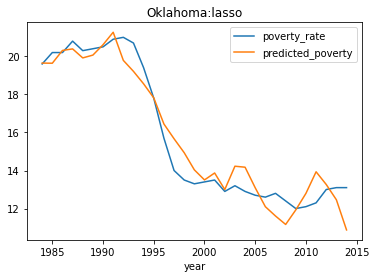

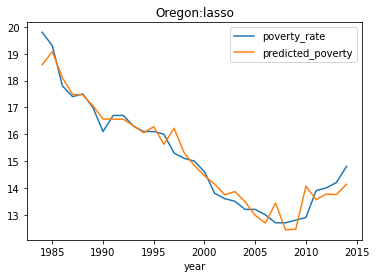

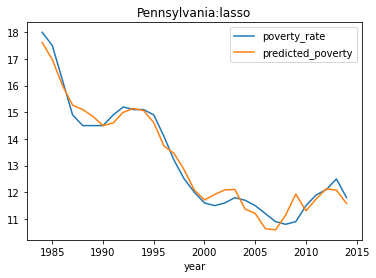

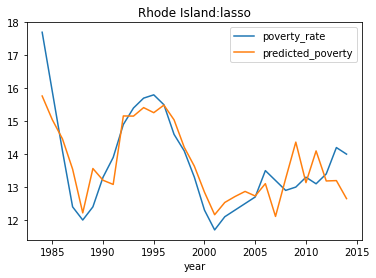

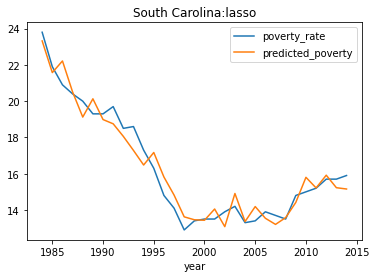

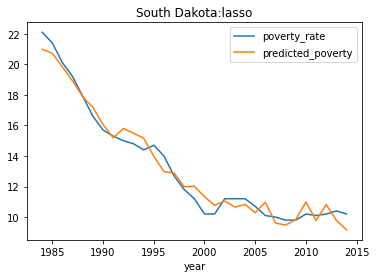

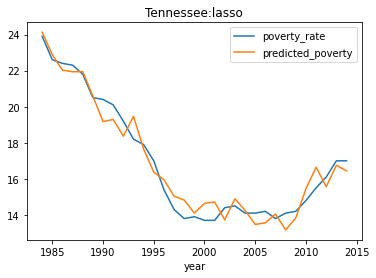

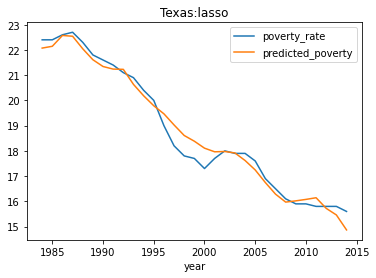

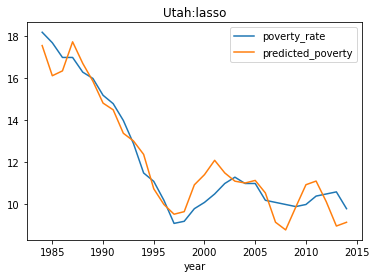

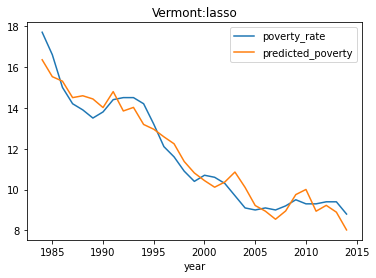

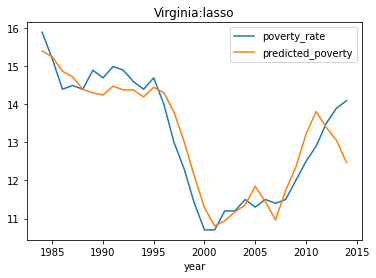

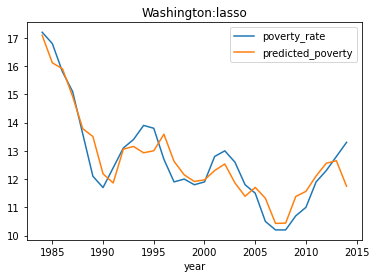

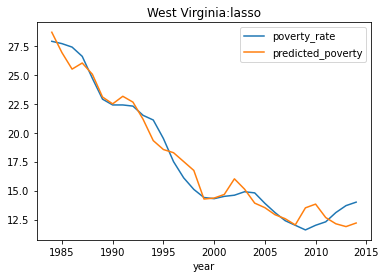

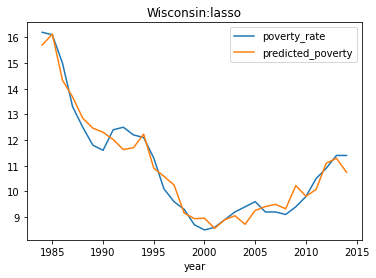

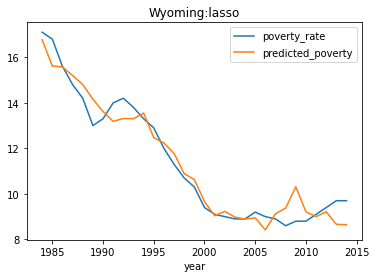

In [116]:
for state in model_df.state.unique():
    result = run_model(model_df, state, 'lasso')
 #   result_df = result_df.append(result, ignore_index=True)

In [83]:
result_df.shape

(102, 7)

In [84]:
result3_df = pd.DataFrame()
result3_df = result_df[result_df.Model=='linear'].copy()
result3_df.dtypes
r2_linear = result3_df['r2 score'].tolist()
r2_ridge = result_df.loc[result_df.Model=='ridge']['r2 score'].tolist()
result3_df['r2 score ridge']=r2_ridge
result3_df['delta r2']=result3_df['r2 score']-result3_df['r2 score ridge']
result3_df= result3_df.set_index('State').sort_values(by='delta r2', ascending=True)
result3_df

Coefficients   Intercept  \
State                                                                           
New Jersey      [-3.232676326249603, -0.002756971746198131, 0....  112.377560   
Minnesota       [-20.550405677951556, -0.0035305106764006323, ...   86.190781   
Louisiana       [-22.41423819237851, 0.014717063985795776, 1.1...  267.727070   
National        [0.005890135937073247, -0.003970836972573085, ...   21.862024   
Missouri        [-20.870804288622118, 0.004107720600766591, 1....  104.814263   
Idaho           [3.2395230422474937, -0.0003478690780620858, 0...   -4.035270   
Connecticut     [-6.12448108555078, -0.008394409906488733, 0.1...   -5.794072   
Maryland        [1.6648572189518311, -0.005818083977077208, 0....   25.058754   
Ohio            [-11.245675836503077, 0.0007865860330483702, 0...  185.103845   
Utah            [17.892208905254755, -0.02574340687638636, 0.2...   51.979615   
Montana         [-57.017541233106755, 0.004136677457634533, 0....  116.347103   
Indiana         [-13.049231332963524, -0.012681516217272095, 0...   80.904228   
Oklahoma        [17.769842803861874, 0.02094009266304077, 1.68...  -63.013750   
Georgia         [-3.4649291094503423, -0.007813248899482565, 0...   11.952754   
Tennessee       [-15.62010981058545, -0.014304670664343572, 0....  113.578831   
Maine           [52.33711055213035, -0.033970230090194155, 0.9...  -14.922073   
Iowa            [27.068430528897956, 0.008657705302057736, 0.7...  -19.049323   
North Carolina  [-9.857137743558106, -0.008657366708545685, 0....   94.698927   
New York        [1.6672761449698699, -0.0019514596696629056, 0...   -5.172445   
Pennsylvania    [4.644365100261324, -0.01001799380142181, 0.60...  -44.086643   
New Mexico      [-0.8254360421933522, 0.0061594854002818555, 0...   13.271277   
Texas           [1.3302577267044988, 0.000607478848640991, 0.5...   26.754541   
Wyoming         [79.78583553457447, 0.004803572232425705, -0.3...    0.099276   
Hawaii          [-135.06012682692665, 0.010870004618264704, 0....   61.640234   
Arkansas        [-35.40465949278749, -0.01889011455140777, 1.6...   69.269512   
South Dakota    [14.765537295015163, 0.024091590025295116, 1.9...    1.357688   
Florida         [-5.5377974838956625, 0.0006511415318351997, 0...   49.313840   
Virginia        [-11.093849913120998, -0.02014611900934037, 0....   77.406929   
Mississippi     [-56.58273892561668, 0.004285448509346388, 0.9...  224.881387   
Vermont         [-100.65402559529502, -0.012841016902024747, 0...   72.771301   
Oregon          [-1.7244554178573896, 0.012540180993699412, 0....   56.161780   
Alabama         [-58.719853524932525, -0.009594440789896344, 0...  254.124293   
Michigan        [4.671452594695619, -0.0002682227234777164, 0....   23.271760   
Nevada          [-15.892744558483969, 0.000529350097010514, 0....   31.482182   
Illinois        [-6.44672020260972, -0.004788097587144036, 0.4...  103.168275   
North Dakota    [52.632397679682455, 0.006117765257337066, 1.5...  -11.074148   
Wisconsin       [0.10982751312523802, -0.0072999030491700196, ...   43.180154   
West Virginia   [30.68197676324084, -0.012446782321183342, 0.8...   36.538838   
Massachusetts   [4.86212465484967, 0.002134666529425096, 0.290...   -7.461770   
California      [-2.202789960585504, 0.008559006813107454, 0.2...   37.470659   
South Carolina  [-14.793319257527621, -0.00988546791391869, 0....   85.399804   
New Hampshire   [-50.67165464127875, 0.0012100336826827345, 0....   19.109506   
Arizona         [-3.3918850803279366, -0.0004145201004627079, ...   53.303991   
Kansas          [-65.27162717887283, -0.002825987779633858, 0....  121.949643   
Colorado        [-5.755623204145349, 0.0028944051227186205, 0....   96.814627   
Alaska          [-99.78050236366317, -0.017689146892009563, -0...  105.885235   
Nebraska        [58.49438064984155, -0.010082193210492947, 0.0...  -31.789569   
Delaware        [76.1035389471044, 0.000876286683893924, 0.318...  -78.535137   
Rho

<AxesSubplot:ylabel='State'>

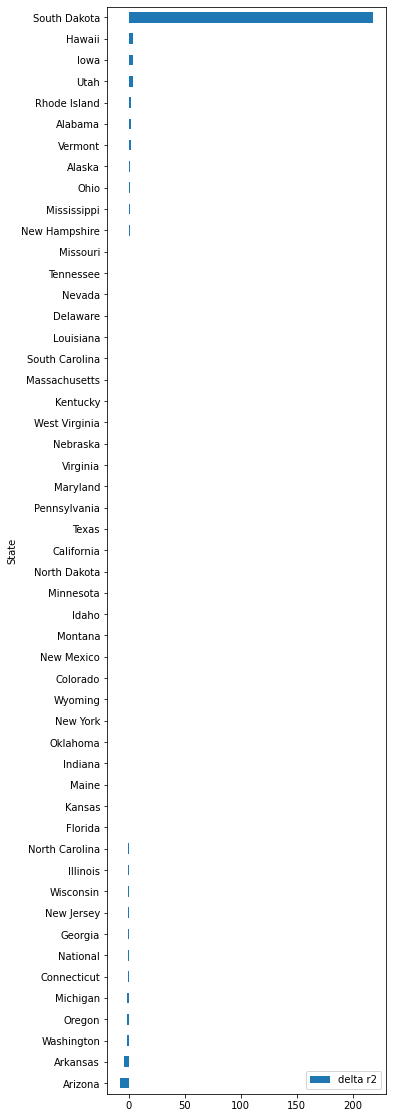

In [79]:
result3_df.plot(y='delta r2',kind='barh',use_index=True, figsize=(5,20))